In [1]:
import glob
from hydra import compose, initialize
import numpy as np
import pandas as pd
import torch
import yaml
from omegaconf import DictConfig, OmegaConf
from dl4cv.utils.utils import set_seed
from dl4cv.lightning_classes.plmodel import LitCVModel
from dl4cv.datasets import HotDogNotHotDog
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
from dl4cv.utils.utils import set_seed

In [3]:
initialize(config_path="../dl4cv02514/configs")
inference_cfg = compose(config_name="config_hotdog_training")
inference_cfg["inference"]["run_name"] = 'stefconv'
inference_cfg["inference"]["device"] = 'cuda'
inference_cfg["inference"]["saliency_params"]["num_samples"] = '50'
path = f"outputs/{inference_cfg.inference.run_name}/.hydra/config.yaml"
with open(path) as cfg:
    cfg_yaml = yaml.safe_load(cfg)
cfg_yaml["inference"] = inference_cfg["inference"]
cfg = OmegaConf.create(cfg_yaml)


/tmp/ipykernel_13675/380158338.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../dl4cv02514/configs")


In [4]:
set_seed(cfg.training.seed)

In [5]:
device = torch.device(cfg.inference.device)

model_names = glob.glob(f"outputs/{cfg.inference.run_name}/saved_models/*.ckpt")
test_set = HotDogNotHotDog(cfg).test
loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    num_workers=1,
    shuffle=False,
)
lit_model = LitCVModel.load_from_checkpoint(checkpoint_path=model_names[0], cfg=cfg)
lit_model.to(device)
print("Model Ready")

Model Ready


In [6]:
misclass_indices = []
misclassified_images = []
corrclass_indices = []
corrclassified_images = []
for i,batch in enumerate(tqdm(loader)):
    target = batch[1]
    prediction = int(torch.sigmoid(lit_model.forward(batch[0].to(device)))>0.5)
    if target != prediction:
        misclass_indices.append(i)
        misclassified_images.append(batch[0].squeeze().numpy())
    else:
        corrclass_indices.append(i)
        corrclassified_images.append(batch[0].squeeze().numpy())
print(f'Total number of misclassification: {len(misclass_indices)}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 931/931 [00:05<00:00, 176.09it/s]

Total number of misclassification: 363


In [7]:
def plot_saliency(index, image,sigma):
    saliency_map = np.load(f"outputs/{cfg.inference.run_name}/saliency_maps_sigma_{sigma}/saliency_map_{index}.npy")
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(saliency_map, cmap=plt.cm.viridis)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [8]:
def plot_saliency_for_sigmas(index,image,sigmas):
    '''
    Create a function to plot saliency map for different sigmas along the same row
    '''
    fig, axs = plt.subplots(1, len(sigmas)+1, figsize=(10, 10))
    axs[0].imshow(np.transpose(image, (1, 2, 0)))
    for i, sigma in enumerate(sigmas):
        saliency_map = np.load(f"outputs/{cfg.inference.run_name}/saliency_maps_sigma_{sigma}/saliency_map_{index}.npy")
        axs[i+1].imshow(saliency_map, cmap=plt.cm.viridis)
        axs[i+1].set_title(f'Sigma = {sigma}')
        axs[i+1].set_xticks([])
        axs[i+1].set_yticks([])
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


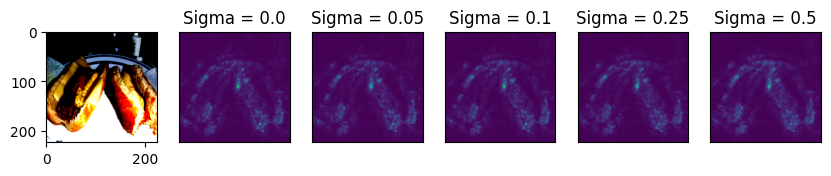

In [9]:
plot_saliency_for_sigmas(corrclass_indices[16], corrclassified_images[16],[0.0,0.05,0.1,0.25,0.5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


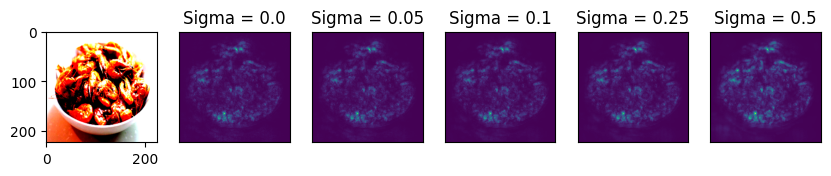

In [11]:
plot_saliency_for_sigmas(misclass_indices[15], misclassified_images[15],[0.0,0.05,0.1,0.25,0.5])